In [11]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
N_Samples = 1000

In [3]:
try:
    data = pd.read_csv(f'../Datasets/datasetMulti_original.csv')
except FileNotFoundError:
    print("Error: No se encontró el archivo 'datasetMulti_original.csv'.")
    exit()

In [ ]:
data = data.drop(columns=['ID', 'No_Pation'], errors='ignore')
data['CLASS'] = data['CLASS'].astype(str).str.strip()
data['Gender'] = data['Gender'].str.strip().str.upper()

data.dropna(inplace=True)

target_column = 'CLASS'
categorical_features = ['Gender']
numerical_features = [col for col in data.columns if col not in categorical_features + [target_column]]

label_encoder_y = LabelEncoder()
data[target_column] = label_encoder_y.fit_transform(data[target_column])
print(f"Mapeo de clases: {dict(zip(label_encoder_y.classes_, label_encoder_y.transform(label_encoder_y.classes_)))}")

label_encoders_X = {}
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders_X[col] = le

Mapeo de clases: {'N': 0, 'P': 1, 'Y': 2}


In [6]:
min_class_count = data['CLASS'].value_counts().min()
if N_Samples > len(data) or int(N_Samples * data['CLASS'].value_counts(normalize=True).min()) > min_class_count:
     print(f"Advertencia: El tamaño de muestra es muy grande. Se usará el dataset completo.")
     data = data.copy()
else:
    proportions = data['CLASS'].value_counts(normalize=True)
    data = data.groupby('CLASS', group_keys=False).apply(
        lambda x: x.sample(int(N_Samples * proportions[x.name]), random_state=42)
    )

print(f"Dataset para el entrenamiento ahora tiene {len(data)} filas.")
print("\nProporción de clases en el nuevo dataset:")
print(data['CLASS'].value_counts(normalize=True))

Dataset para el entrenamiento ahora tiene 1000 filas.

Proporción de clases en el nuevo dataset:
CLASS
2    0.844
0    0.103
1    0.053
Name: proportion, dtype: float64


In [ ]:
X = data.drop(columns=[target_column])
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Escalamiento de características numéricas completado.")

X_train_np = X_train.values.astype(np.float32)
y_train_np = y_train.values
X_test_np = X_test.values.astype(np.float32)
y_test_np = y_test.values

Escalamiento de características numéricas completado.


In [ ]:
cat_idxs = [X.columns.get_loc(col) for col in categorical_features]
cat_dims = [len(le.classes_) for le in label_encoders_X.values()]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
class_weights = torch.tensor([9.71, 18.87, 1.18], device=DEVICE)
weighted_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    optimizer_params=dict(lr=1e-3),
    optimizer_fn=torch.optim.Adam,
    verbose=1,
    seed=42
)

print(f"\n Iniciando Entrenamiento de TabNet:{' ' + DEVICE.upper()}")
clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    patience=20,
    max_epochs=500,
    batch_size=128,
    eval_metric=['accuracy', 'logloss'],
    loss_fn=weighted_loss
)


 Iniciando Entrenamiento de TabNet: CPU
epoch 0  | loss: 1.32579 | val_0_accuracy: 0.415   | val_0_logloss: 1.11003 |  0:00:00s
epoch 1  | loss: 1.00131 | val_0_accuracy: 0.575   | val_0_logloss: 0.99149 |  0:00:00s
epoch 2  | loss: 0.93373 | val_0_accuracy: 0.535   | val_0_logloss: 0.94186 |  0:00:00s
epoch 3  | loss: 0.8631  | val_0_accuracy: 0.675   | val_0_logloss: 0.77662 |  0:00:00s
epoch 4  | loss: 0.78862 | val_0_accuracy: 0.815   | val_0_logloss: 0.5756  |  0:00:00s
epoch 5  | loss: 0.73981 | val_0_accuracy: 0.865   | val_0_logloss: 0.43836 |  0:00:00s
epoch 6  | loss: 0.64182 | val_0_accuracy: 0.84    | val_0_logloss: 0.4861  |  0:00:00s
epoch 7  | loss: 0.62088 | val_0_accuracy: 0.81    | val_0_logloss: 0.48426 |  0:00:01s
epoch 8  | loss: 0.57781 | val_0_accuracy: 0.87    | val_0_logloss: 0.42046 |  0:00:01s
epoch 9  | loss: 0.50196 | val_0_accuracy: 0.87    | val_0_logloss: 0.36185 |  0:00:01s
epoch 10 | loss: 0.44454 | val_0_accuracy: 0.905   | val_0_logloss: 0.23918 |  

In [12]:
directorio = os.getcwd()
carpeta = "../Guardar_modelo/TabNet"
archivo_xgb = f'Multi_TabNet_{N_Samples}'

ruta = os.path.join(directorio, carpeta, archivo_xgb)

directorio_final_para_guardar = os.path.dirname(ruta)
os.makedirs(directorio_final_para_guardar, exist_ok=True)

clf.save_model(ruta)

Successfully saved model at c:\Users\tcidm\OneDrive\Escritorio\Material U\DeepLearning\ProyectoDeepLearning\Modelo_TabNet\../Guardar_modelo/TabNet\Multi_TabNet_1000.zip


'c:\\Users\\tcidm\\OneDrive\\Escritorio\\Material U\\DeepLearning\\ProyectoDeepLearning\\Modelo_TabNet\\../Guardar_modelo/TabNet\\Multi_TabNet_1000.zip'


--- Resultados de la Evaluación Final ---
Precisión (Accuracy) en el conjunto de prueba: 0.9900

Reporte de Clasificación:
              precision    recall  f1-score   support

           N       1.00      0.90      0.95        21
           P       1.00      1.00      1.00        10
           Y       0.99      1.00      0.99       169

    accuracy                           0.99       200
   macro avg       1.00      0.97      0.98       200
weighted avg       0.99      0.99      0.99       200


Matriz de Confusión:


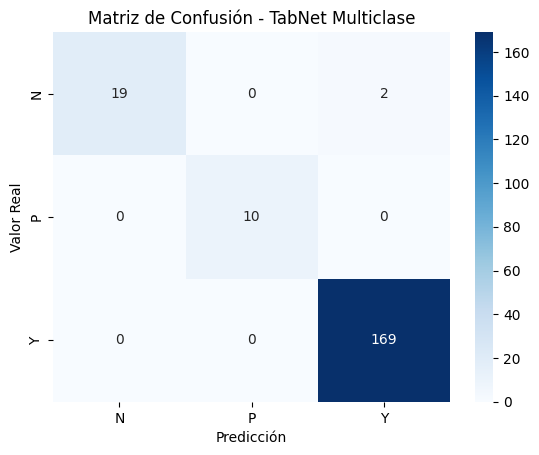

              precision    recall  f1-score   support

           N       1.00      0.90      0.95        21
           P       1.00      1.00      1.00        10
           Y       0.99      1.00      0.99       169

    accuracy                           0.99       200
   macro avg       1.00      0.97      0.98       200
weighted avg       0.99      0.99      0.99       200


Curva de Pérdida del Entrenamiento:


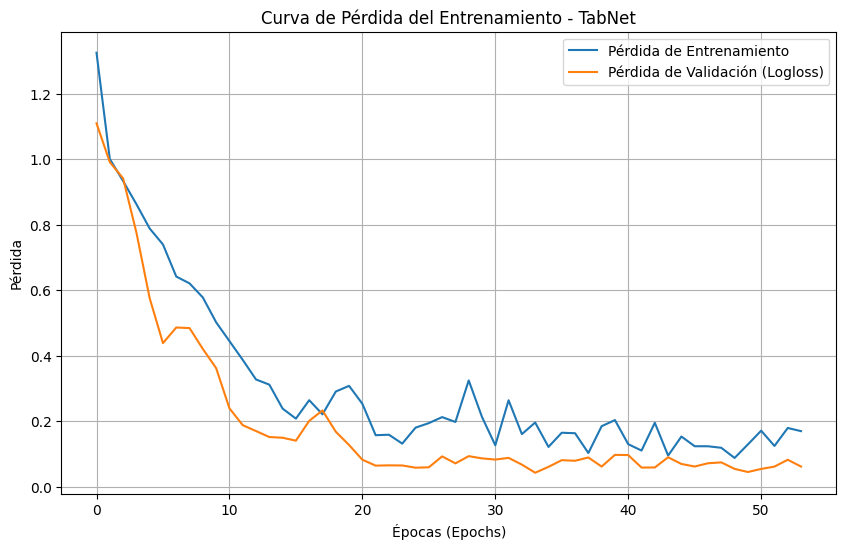

In [13]:
#Carga del modelo guardado
#preTrained = TabNetClassifier()
#preTrained.load_model(ruta)

y_pred = clf.predict(X_test_np)
test_accuracy = accuracy_score(y_test_np, y_pred)

print(f"\n--- Resultados de la Evaluación Final ---")
print(f"Precisión (Accuracy) en el conjunto de prueba: {test_accuracy:.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_test_np, y_pred, target_names=label_encoder_y.classes_))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test_np, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_y.classes_, yticklabels=label_encoder_y.classes_)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - TabNet Multiclase')
plt.show()

print(classification_report(y_test_np, y_pred, target_names=['N', 'P', 'Y']))

print("\nCurva de Pérdida del Entrenamiento:")
plt.figure(figsize=(10, 6))
plt.plot(clf.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(clf.history['val_0_logloss'], label='Pérdida de Validación (Logloss)')
plt.title('Curva de Pérdida del Entrenamiento - TabNet')
plt.xlabel('Épocas (Epochs)')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()